In [1]:
import env
import gymnasium as gym 
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# load training data - 1-min sampling rate
file_path = os.path.abspath('')
parent_path = os.path.dirname(file_path)
data_path = os.path.join(parent_path, 'data/disturbance_1min.csv')
data = pd.read_csv(data_path, index_col=[0])
index = range(0, len(data)*60, 60)
data.index = index

# sample every hour
dt = 900
data = data.groupby([data.index // dt]).mean()
n = len(data)

In [3]:
data.head()


,out_temp,qint_lump,qhvac_lump,qwin_lump,qradin_lump,weighted_average
0,20.293333,0.480332,0.0,0.0,0.012347,19.160666
1,20.843333,0.425317,0.0,0.0,0.012347,23.732525
2,21.393333,0.425388,0.0,0.0,0.012347,24.470429
3,21.943333,0.430628,0.0,0.0,0.012347,24.782301
4,22.173333,0.432306,0.0,0.0,0.012347,24.946116


In [4]:
disturbance_names = ['out_temp', 'qint_lump', 'qwin_lump', 'qradin_lump']
disturbance = data[disturbance_names].values

u = data['qhvac_lump'].values

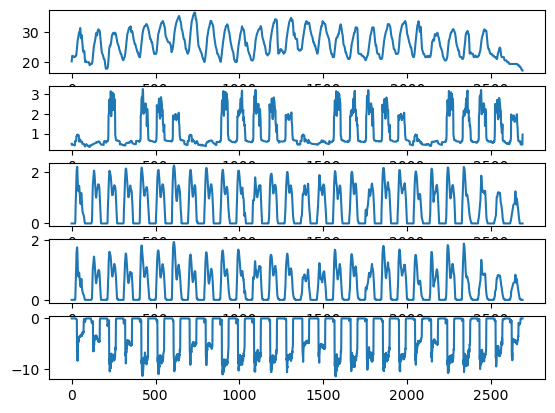

In [5]:
plt.figure()
plt.subplot(5,1,1)
plt.plot(disturbance[:,0], label="Outdoor Temp")

plt.subplot(5,1,2)
plt.plot(disturbance[:, 1], label="q_int")

plt.subplot(5,1,3)
plt.plot(disturbance[:,2], label='q_win')

plt.subplot(5,1,4)
plt.plot(disturbance[:,3], label="q_rad")

plt.subplot(5,1,5)
plt.plot(u, label="q_hvac")



In [6]:
# test rc state space
#rc_params = [10383.181640625, 499116.65625, 1321286.5, 1.53524649143219, 0.5000227689743042, 1.0003612041473389, 20.09742546081543]
rc_params = [6.9789902e+03, 2.1591113e+04, 1.8807944e+05, 3.4490612e+00, 4.9556872e-01, 9.8289281e-02, 4.6257420e+00]

x0 = np.array([19, 36, 25])
x_high = np.array([40., 80., 40.])
x_low = np.array([10., 10., 10.])
n_actions = 1201
u_high = [0]
u_low = [-12.0]

t_d = [t*dt for t in range(n)]


In [7]:
A = np.array([[-1.97402551e-04,  0.00000000e+00,  1.92610415e-04],
       [ 0.00000000e+00, -3.30784418e-06,  2.00281620e-06],
       [ 1.51360733e-06,  7.56564853e-07, -2.27017218e-06]])
Bu = np.array([[9.63095932e-05], [0.], [0.]])
Bd = np.array([[4.79213586e-06, 9.63095932e-05, 0.00000000e+00, 0.00000000e+00],
       [1.30502798e-06, 0.00000000e+00, 2.00353963e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.56838127e-07]])
C = np.array([[1., 0., 0.],
       [0., 0., 0.]])
D = np.array([[0.],
            [1.]])

In [8]:
# test linear state space gym env
import env.r4c3_discrete as rc

disturbances = [t_d, disturbance]

dist_fcn = rc.LinearInterpolation(*disturbances)
lssm = gym.make("DiscreteLinearStateSpace-v0",
                A = A,
                Bu = Bu, 
                Bd = Bd,
                C = C,
                D = D,
                x0 = x0,
                dist_fcn = dist_fcn,
                x_high = x_high,
                x_low = x_low,
                n_actions = n_actions,
                u_high = u_high,
                u_low = u_low,
                ts = 0,
                te = dt*24.,
                dt = dt).env

state0, _ = lssm.reset(seed=0)
assert lssm.observation_space.shape[0] == lssm.state.shape[0], "state shape does not match observation space shape"
assert lssm.action_space.n == n_actions, "action space does not match n_actions"
assert lssm.t == lssm.ts, "initial time does not match given start time"
assert np.any(lssm.state.astype(np.float32) == state0), "initial state does not match given initial state"

# sample actions from action space
# step 1
lssm.action_space.seed(12)
action = lssm.action_space.sample() # sample action from action space
state1, reward1, done1, _, _ = lssm.step(action) # step the environment
assert lssm.t == lssm.ts + lssm.dt, "time does not match given time step"
assert done1 == lssm.done, "done does not match environment done"
assert reward1 == 1, "reward does not match given reward"
assert np.any(lssm.state.astype(np.float32) == state1), "state does not match given state"

# step 2
action = lssm.action_space.sample()
state2, reward2, done2, _, _ = lssm.step(action)
assert lssm.t == lssm.ts + 2*lssm.dt, "time does not match given time step"
assert done2 == lssm.done, "done does not match environment done"
assert reward2 == 1, "reward does not match given reward"
assert np.any(lssm.state.astype(np.float32) == state2), "state does not match given state"

# reset environment
state3, _ = lssm.reset(seed=0)
assert lssm.t == lssm.ts, "time does not match given start time"
assert np.any(lssm.state.astype(np.float32) == state3), "state does not match given state"
assert np.any(state3 == state0), "state does not previous initial state"

/opt/conda/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [9]:
ts = 0
te = 2*7*24*3600

env = gym.make("R4C3Discrete-v0",
    rc_params = rc_params,
    x0 = x0,
    x_high = x_high,
    x_low = x_low,
    n_actions = n_actions,
    u_high = u_high,
    u_low = u_low,
    disturbances = (t_d, disturbance),
    ts = 0,
    te = te,
    dt = dt)

obs0, _ = env.reset(seed=0)
assert env.observation_space.shape[0] == env.observation.shape[0], "observation shape does not match observation space shape"


# step
env.action_space.seed(0)
action1 = env.action_space.sample()
obs1, reward1, terminated, _, info1 = env.step(action1)
assert env.t == env.ts + env.dt*1, "time does not match given time step"
assert info1["t"] == env.ts + env.dt*1, "time in info does not match given time step"
assert terminated == env.done, "done does not match environment done"
assert reward1 <= 0, "reward does not match the reward range"

# step
action2 = env.action_space.sample()
obs2, reward2, terminated, _, info2 = env.step(action2)
assert env.t == env.ts + env.dt*2, "time does not match given time step"
assert info2["t"] == env.ts + env.dt*2, "time in info does not match given time step"
assert terminated == env.done, "done does not match environment done"
assert reward2 <= 0, "reward does not match the reward range"

# reset
obs3, _ = env.reset(seed=0)
assert env.t == env.ts, "time does not match given start time"
assert np.any(env.observation.astype(np.float32) == obs3), "state does not match given state"
assert np.any(obs3 == obs0), "state does not previous initial state"


env is reset!
env is reset!


/opt/conda/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [10]:
# test continuous simulation
obs, _ = env.reset(seed=0)

i = 0
done = False

t = [env.t]
Tz = [obs[1]]
q_hvac = [0.]
while i < n and not done:
    action = (u[i] - np.array(u_low))*(n_actions - 1) / (np.array(u_high) - np.array(u_low))
    action = int(action)
    print(u[i], action)
    obs, reward, done, _, info = env.step(action)
    t.append(info["t"])
    Tz.append(obs[1])
    q_hvac.append(u[i])
    
    i += 1


env is reset!
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
0.0 1200
-0.03245003513200515 1196
-0.12878727325267972 1187
-0.1423686929170677 1185
-0.22115129236169476 1177
-0.22597569576174775 1177
-6.65912203845517 534
-6.632446465029095 536
-6.5184458916271995 548
-8.38930250691143 361
-7.144543752957817 485
-6.06870226947207 593
-5.311831232129465 668
-4.480122239618236 751
-4.687024794249681 731
-4.366439911490359 763
-3.9982443551603426 800
-4.337646661760375 766
-3.787156721841949 821
-3.6442876541808844 835
-3.695754529503698 830
-3.5429035529374153 845
-3.666137270057213 833
-3.474612539507512 852
-3.653783478073132 834
-3.6655854221776503 833
-3.392888903160423 860
-3.5529381333960233 844
-3.331310008925311 866
-3.291224501213402 870
-3.387863741997468 861
-3.1811081081391697 881
-3.491039999

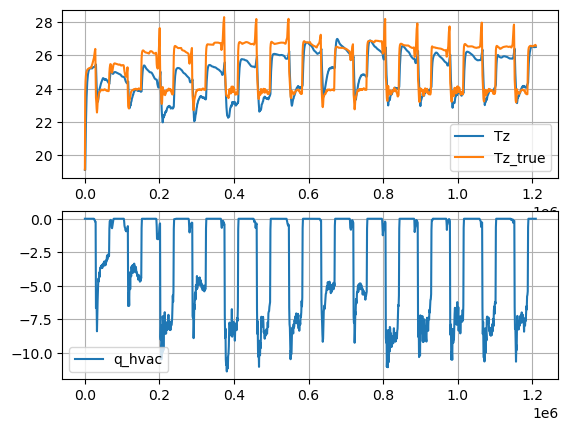

In [11]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, Tz, label="Tz")
plt.plot(t, data['weighted_average'][:len(Tz)], label="Tz_true")
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, q_hvac, label="q_hvac")
plt.grid()
plt.legend()
plt.savefig('simulation.png')
